In [1]:
# TPX event display, bjpj 2024 (ben.jones@uta.edu)

In [2]:
import tpx
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import gaussian_filter


In [3]:
def Read_data(files):
    datadic={}
    count=0
    for i in files:
        datadic[count]=tpx.parse_binary_file(i)
        count=count+1
    return datadic

tpx_data=Read_data(["./160thresh_12biasvolt_IIgain0_0V000000.tpx3"])


In [4]:
x=tpx_data[0]['x']
y=tpx_data[0]['y']
tot=tpx_data[0]['TOT']
toa=tpx_data[0]['TOA']

In [5]:
# Make a grid for histogramming
AllXs=np.sort(np.unique(x))
AllYs=np.sort(np.unique(y))
XX,YY=np.meshgrid(AllXs,AllYs)

In [6]:
#Find the high pixels to mask
cts=np.histogram2d(x,y,bins=(range(260,517),range(0,257)))
MaskThresh=250   # NB: adjust this for good results
mask=cts[0]>MaskThresh

XMask=XX.T[mask]
YMask=YY.T[mask]


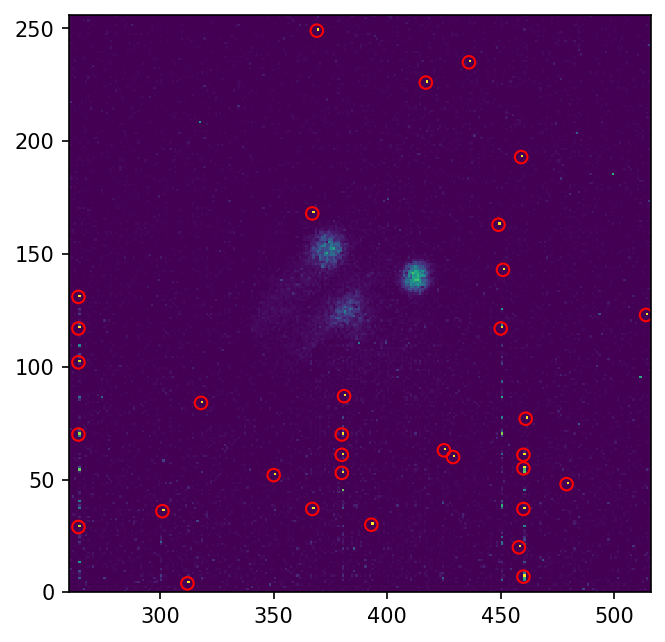

In [7]:
plt.figure(figsize=(5,5),dpi=150)


cts=plt.hist2d(x,y,bins=(range(260,517),range(0,257)))
plt.clim(0,300)
plt.scatter(XMask,YMask,facecolors='none', edgecolors='r')

In [8]:
#Select only unmasked hits

xsel=x
ysel=y
totsel=tot
toasel=toa
for i in range(0,len(XMask)):
    keep=np.logical_not((xsel==XMask[i])*(ysel==YMask[i]))
    xsel=xsel[keep]
    ysel=ysel[keep]
    totsel=totsel[keep]
    toasel=toasel[keep]

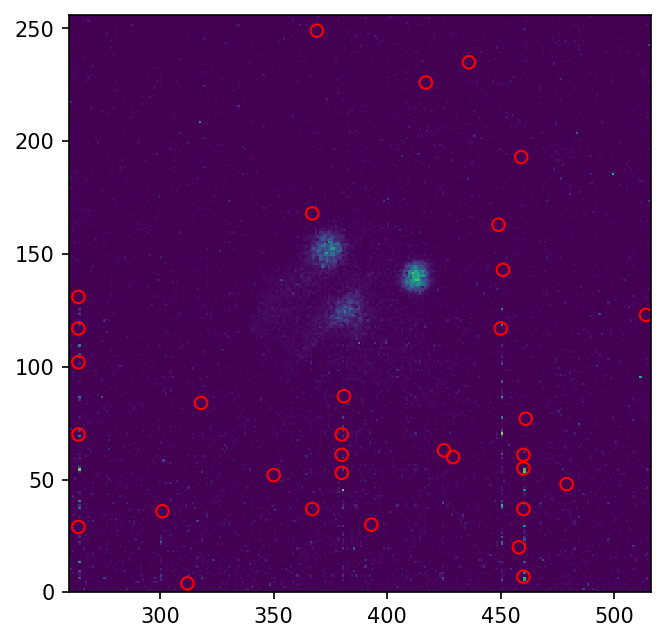

In [9]:
#Check we did it

plt.figure(figsize=(5,5),dpi=150)
cts=plt.hist2d(xsel,ysel,bins=(range(260,517),range(0,257)))
plt.clim(0,300)
plt.scatter(XMask,YMask,facecolors='none', edgecolors='r')
#plt.xlim(360,430)
#plt.ylim(105,175)

In [10]:

#Apply a tot threshold and scale the space and time axes

thr=150           # threshold for tot to show hits
xpix=0.5          # x axis scale factor 
ypix=0.5          # y axis scale factor
tpix=1e-6         # t axis scale factor
StepLength=0.2    # how mcuh to move each frame
FrameSize=35      # how tall is each frame
Frames=1000       # how many frames to make
start=0           # where in the event to start
twidth2=2.*10**2  # width of smear kernel in t
xwidth = 1        # width of smearing in x  

XBins=np.arange(360/2,430/2+1,xpix)        # X bins to plot in 2D
YBins=np.arange(100/2,170/2+1,ypix)        # Y bins to plot in 2D
XXX,YYY=np.meshgrid(XBins[:-1],YBins[:-1]) # meshgrids 


In [11]:
# Select above threshold hits

xovert=xsel[totsel>thr]*xpix
yovert=ysel[totsel>thr]*ypix
toaovert=(toasel[totsel>thr]-np.min(toasel))*tpix
totovert=totsel[totsel>thr]


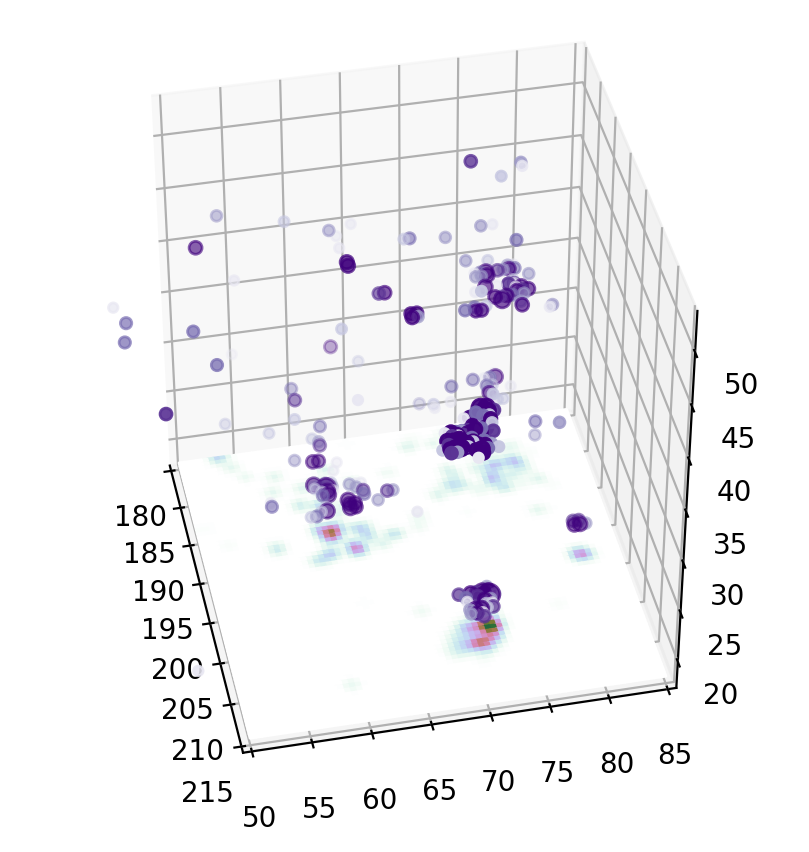

In [12]:
#Make one frame as an example
fig = plt.figure(figsize=(5,5),dpi=200)
ax = fig.add_subplot(projection='3d',computed_zorder=False)

#i in the frame number
i=90

# make smeared integral for bottom plane
TwoDPictureWeights=np.exp(-(toaovert-(i*StepLength))**2/twidth2)*totovert
hist=np.histogram2d(xovert,yovert,weights=TwoDPictureWeights,bins=(XBins,YBins))
filtered_arr=gaussian_filter(hist[0], xwidth)

#pick only hits in this z region
pick=(toaovert>(i*StepLength))*(toaovert<(i*StepLength+FrameSize))

#make the plot
ax.plot_surface(XXX, YYY, np.ones_like(XXX)*i*StepLength, rstride=1, cstride=1, facecolors=plt.cm.cubehelix_r(filtered_arr.T/500), shade=False,zorder=1)
ax.scatter(xovert[pick], yovert[pick], toaovert[pick],s=(totovert[pick]/15),c=totovert[pick],zorder=10,cmap='Purples',vmin=thr,vmax=300)

ax.set_xlim(XBins[0],XBins[-2])
ax.set_ylim(YBins[0],YBins[-2])
ax.set_zlim(i*StepLength,i*StepLength+FrameSize)

# projection angle and aspect ratio
ax.view_init(40, -30+i*0.2, 0)
ax.set_box_aspect((1,1,1.1))

    

In [12]:
matplotlib.use('Agg')  # Warning - this will make plots no longer display but just write to disk.
                       #  Restart kernel if you want to get them back inline.
    

In [ ]:

# Make all the plots and store them in ./tmp/
for j in range(0,Frames):
    fig = plt.figure(figsize=(5,5),dpi=200)
    ax = fig.add_subplot(projection='3d',computed_zorder=False)

    #i in the frame number
    i=j+start

    # make smeared integral for bottom plane
    TwoDPictureWeights=np.exp(-(toaovert-(i*StepLength))**2/twidth2)*totovert
    hist=np.histogram2d(xovert,yovert,weights=TwoDPictureWeights,bins=(XBins,YBins))
    filtered_arr=gaussian_filter(hist[0], xwidth)
    
    #pick only hits in this z region
    pick=(toaovert>(i*StepLength))*(toaovert<(i*StepLength+FrameSize))
    
    #make the plot
    ax.plot_surface(XXX, YYY, np.ones_like(XXX)*i*StepLength, rstride=1, cstride=1, facecolors=plt.cm.cubehelix_r(filtered_arr.T/500), shade=False,zorder=1)
    ax.scatter(xovert[pick], yovert[pick], toaovert[pick],s=(totovert[pick]/15),c=totovert[pick],zorder=10,cmap='Purples',vmin=thr,vmax=300)
    
    ax.set_xlim(XBins[0],XBins[-2])
    ax.set_ylim(YBins[0],YBins[-2])
    ax.set_zlim(i*StepLength,i*StepLength+FrameSize)

    # projection angle and aspect ratio
    ax.view_init(40, -30+i*0.2, 0)
    ax.set_box_aspect((1,1,1.1))

    # save it and free the memory
    plt.savefig("./tmp/"+str(j).zfill(4)+".png",dpi=150)
    matplotlib.pyplot.close()
    
    
#plt.xlim(360,430)
#plt.ylim(105,175)
 

In [ ]:
#Now make a gif
import imageio

outpath="./movie.gif"
files=sorted(os.listdir("./tmp"))

with imageio.get_writer(outpath, mode='I',duration=25,loop=10000) as writer:
    for filename in files:
        if('.png' in filename):
            image = imageio.imread("tmp/"+filename)
            writer.append_data(image)